## Importing Libraries 

In [203]:
import numpy as np
import pandas as pd 
from datetime import datetime
import matplotlib 
import matplotlib.pyplot as plt 
from matplotlib import colors 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from yellowbrick.cluster import KElbowVisualizer 
from sklearn.cluster import KMeans 
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.cluster import AgglomerativeClustering 
from matplotlib.colors import ListedColormap
from sklearn import metrics 
import warnings 
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

## Loading Data 

In [204]:
data = pd.read_csv("./data/marketing_campaign.csv", sep="\t")
print('Number of datapoints', len(data))
data.head()

Number of datapoints 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data cleaning

In [205]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

From the about output, we can conclude and note that: 
- There are missing value in income 
- Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime 
- There are some categorical features in our data frame, there are some features. So we will need to encode them into numeric forms later. 

First of all, for the missing values, I am simply going to drop the rows that have missing income values. 

In [206]:
data = data.dropna()
print('The total number of data-points after removing the rows with missing values are', len(data))

The total number of data-points after removing the rows with missing values are 2216


In [207]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')
dates = []
for i in data['Dt_Customer']: 
    i = i.date()
    dates.append(i)
print("The newest customer's enrollment date in the records:", max(dates))
print("The oldest customer's enrollment date in the records:", min(dates))

The newest customer's enrollment date in the records: 2014-06-29
The oldest customer's enrollment date in the records: 2012-07-30


Creating a feature ("Customer_For") of the number of days the customers started to shop in the store relative to the last recorded date. 

In [208]:
days = []
d1 = max(dates)
for i in dates: 
    delta = d1 - i 
    days.append(delta)
data['Customer_For'] = days 
data['Customer-For'] = pd.to_numeric(data['Customer_For'], errors='coerce') 

Now we will be exploring the unique values in the categorical features to get a clear idea of the data

In [209]:
print('Total categories in the feature Marital_Status:\n', data['Marital_Status'].value_counts(),"\n") 
print("Total categories in the feature Education:\n", data['Education'].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In the next bit, I will be performing the following steps to engineer some new features 
- Extract the "Age" of a customer by the "Year_Birth" indicating the birh year of the respective person 
- Create another feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years 
- Create another feature "Children" to indicate total children in a household that is, kids and teenagers 
- To get furthey clarity of household. Creating feature indicating "Family_Size", 
- Create a feature "is_Parent" to indicate parenthood status. 
- Lastly, I will create three categories in the "Education" by simplifying its value counts. 
- Dropping some of the redundants features 

In [210]:
data['Year_Birth']  

0       1957
1       1954
2       1965
3       1984
4       1981
        ... 
2235    1967
2236    1946
2237    1981
2238    1956
2239    1954
Name: Year_Birth, Length: 2216, dtype: int64

In [211]:
now = datetime.now()

In [212]:
now 

datetime.datetime(2025, 5, 16, 15, 16, 43, 271458)

In [213]:
now.year

2025

In [214]:
data['Age'] = now.year - data['Year_Birth'] 

In [215]:
# Total spendings on various items 
data['Spent'] = data['MntWines']+data['MntFruits']+data['MntMeatProducts']+data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds'] 

In [216]:
data['Spent']

0       1617
1         27
2        776
3         53
4        422
        ... 
2235    1341
2236     444
2237    1241
2238     843
2239     172
Name: Spent, Length: 2216, dtype: int64

In [217]:
## Deriving living situation by marital status 'Alone' 
data['Living_With'] = data['Marital_Status'].replace({'Married': 'Partner', "Together": "Partner", 'Absurd': 'Alone', 'Widow': 'Alone', "YOLO": 'Alone', "Divorced": "Alone", "Single": 'Alone'})

In [218]:
data['Living_With'] 

0         Alone
1         Alone
2       Partner
3       Partner
4       Partner
         ...   
2235    Partner
2236    Partner
2237      Alone
2238    Partner
2239    Partner
Name: Living_With, Length: 2216, dtype: object

In [219]:
## Feature indicating total children living in the household 
data['Children'] = data['Kidhome'] + data['Teenhome'] 
data['Children'] 

0       0
1       2
2       0
3       1
4       1
       ..
2235    1
2236    3
2237    0
2238    1
2239    2
Name: Children, Length: 2216, dtype: int64

In [220]:
## Feature for total members in the households 
data['Family_Size'] = data['Living_With'].replace({"Alone": 1, "Partner": 2}) + data['Children'] 
data['Family_Size']

0       1
1       3
2       2
3       3
4       3
       ..
2235    3
2236    5
2237    1
2238    3
2239    4
Name: Family_Size, Length: 2216, dtype: int64

In [221]:
data['Is_Parent'] = np.where(data.Children > 0, 1, 0)

In [222]:
data['Education'] = data['Education'].replace({"Basic": "Undergraduate", "2 Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})

In [223]:
data['Education'] 

0           Graduate
1           Graduate
2           Graduate
3           Graduate
4       Postgraduate
            ...     
2235        Graduate
2236    Postgraduate
2237        Graduate
2238    Postgraduate
2239    Postgraduate
Name: Education, Length: 2216, dtype: object

In [224]:
data = data.rename(columns={"MntWines": "Wines", "MntFruits": "Fruits", "MntMeatProducts":"Meat", "MntFishProducts": "Fish", "MntSweetProducts": "Sweets", "MntGoldProds": "Gold"})

In [225]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   ID                   2216 non-null   int64          
 1   Year_Birth           2216 non-null   int64          
 2   Education            2216 non-null   object         
 3   Marital_Status       2216 non-null   object         
 4   Income               2216 non-null   float64        
 5   Kidhome              2216 non-null   int64          
 6   Teenhome             2216 non-null   int64          
 7   Dt_Customer          2216 non-null   datetime64[ns] 
 8   Recency              2216 non-null   int64          
 9   Wines                2216 non-null   int64          
 10  Fruits               2216 non-null   int64          
 11  Meat                 2216 non-null   int64          
 12  Fish                 2216 non-null   int64          
 13  Sweets               22

In [226]:
to_drop = ['Marital_Status', "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis = 1)

In [227]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp2,Complain,Response,Customer_For,Customer-For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.013538,0.009477,0.150271,353 days 12:30:32.490974728,3.054423e+16,56.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.115588,0.096907,0.357417,202 days 10:25:55.267301594,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0 days 00:00:00,0.000000e+00,29.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,180 days 00:00:00,1.555200e+16,48.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,355 days 12:00:00,3.071520e+16,55.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,529 days 00:00:00,4.570560e+16,66.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,699 days 00:00:00,6.039360e+16,132.000000,2525.000000,3.000000,5.000000,1.000000


The above stats show some discrepancies in mean income and Age and max income and age 
Do note that max-age is 128 years, As i calculated the age that would be today and the data is old 
I must take a look at the broader view of the data. I will plot some of the selected features 

Reletive Plot of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

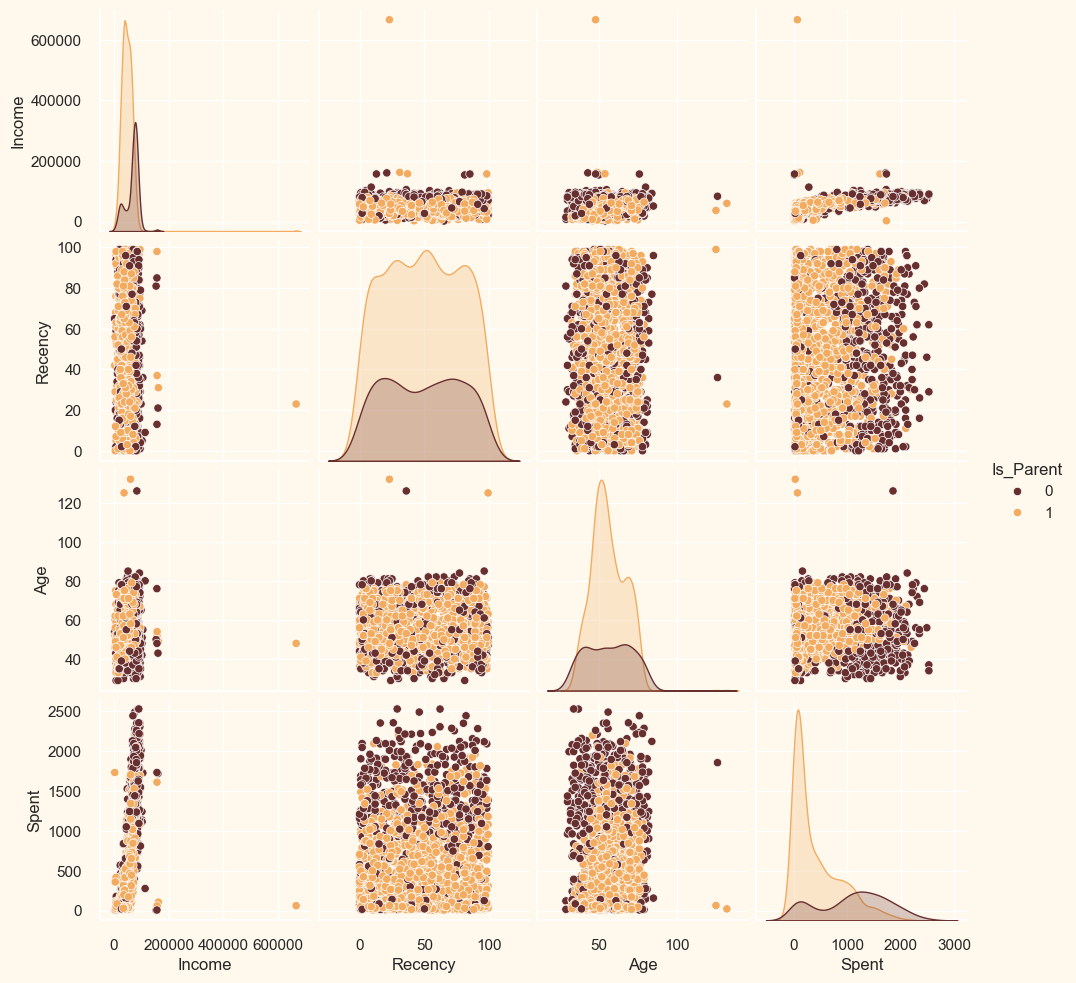

In [228]:
sns.set(rc={"axes.facecolor": "#FFF9ED", "figure.facecolor": "#FFF9ED"})
pallet = ['#682F2F', '#9E726F', '#D6B2B1', '#B9C0C9', '#9F8A78', '#F3AB60'] 
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features 
To_Plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"] 
print("Reletive Plot of Some Selected Features: A Data Subset") 
plt.figure()
sns.pairplot(data[To_Plot], hue="Is_Parent", palette=(["#682F2F", "#F3AB60"]))
plt.show()

Clearly, there are few outliers in the Income and Age features. I will be deleting the outliers in the data

In [229]:
## Dropping the outliers by setting a cap on Age and income 
data = data[(data['Age']<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


Next, let us look at the correlation amongst the features. (Excluding the categorical attributes at this point) 

## Data Preprocessing

In this section, i will be preprocessing the data to perform clustering operations 

The following steps are applied to preprocess the data: 
- Label encoding the categorical features 
- Scaling the features using the standard scaler 
- Creating a subset dataframe for dimensionality reduction 

In [230]:
s = (data.dtypes == 'object') 
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [231]:
LE=LabelEncoder()
for i in object_cols:
    data[i] = data[[i]].apply(LE.fit_transform)
print("All features are now numerical")

All features are now numerical


In [232]:
ds = data.copy()
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response'] 
ds = ds.drop(cols_del, axis=1)
# Scaling
cols_to_keep = [
    col
    for col in data.columns
    if col
    not in [
        "Year_Birth",
        "Age",
        "AcceptedCmp3",
        "AcceptedCmp4",
        "AcceptedCmp5",
        "AcceptedCmp1",
        "AcceptedCmp2",
        "Complain",
        "Response",
        "Customer_For"
    ]
]
scaler = StandardScaler()
scaler.fit(ds[cols_to_keep])
scaled_ds = pd.DataFrame(scaler.transform(ds), columns = ds.columns) 
print("All features are now scaled")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Age
- Customer_For
